# NMR: FEM, Conventional and Analytical

## FEM
\begin{equation}
\frac{\partial m}{\partial t} = \nabla \cdot (D \cdot \nabla m) - \frac{m}{T_{2B}}
\end{equation}

\begin{equation}
m_0 = m_s
\end{equation}

\begin{equation}
n \cdot (D \cdot \nabla m) + \rho m = 0
\end{equation}


\begin{equation}
M(t) = \int_V m \, dV
\end{equation}

## Conventional

\begin{equation}
M(t) = m(0) e^{-t/T_{2}^*}
\end{equation}

\begin{equation}
m(0) = m_s V
\end{equation}

\begin{equation}
T_{2}^* = \frac{V}{\rho S}
\end{equation}

## Analytical

\begin{equation}
M(t) = m(0) \sum_{n=0}^\infty I_n e^{-t(\frac{1}{Tn}+\frac{1}{T_{2B}})}
\end{equation}

\begin{equation}
m(0) = m_s V
\end{equation}

\begin{equation}
T_n = \frac{r^2}{D \varepsilon^2_n}
\end{equation}

\begin{equation}
1 - \varepsilon_n \cot (\varepsilon_n) = \frac{r \rho}{D}
\end{equation}

\begin{equation}
I_n = \frac{12 [\sin (\varepsilon_n) - \varepsilon_n \cos (\varepsilon_n)]^2}{\varepsilon^3_n [2 \varepsilon_n - \sin(2 \varepsilon_n)]}
\end{equation}

In [3]:
import platform, sys, os, shutil
import packaging.version as pv
import time

try:
    from google.colab import files
except:
    print("This is not google.colab")

python_version=platform.python_version()
print('python version:', python_version)

if pv.parse(python_version) < pv.parse("3.0.0"):
    print("Python3 is needed!")
    print("How to fix: Runtime/Change_runtime_type/Python 3")
    sys.exit()

try:
    from dolfin import *
    from dolfin import __version__ as dolfin_version
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import __version__ as mpl_version
    from tqdm import tqdm
    import scipy.optimize as opt
    from scipy.stats import norm
    from scipy.integrate import quad
    from scipy import __version__ as sp_version
    import mpmath
    import mshr
except ImportError as e:
    !wget  "https://fem-on-colab.github.io/releases/fenics-install-real.sh"   -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *
    from dolfin import __version__ as dolfin_version
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import __version__ as mpl_version
    from tqdm import tqdm
    import scipy.optimize as opt
    from scipy.stats import norm
    from scipy.integrate import quad
    from scipy import __version__ as sp_version
    import mpmath
    import mshr

try:
    import gmsh
except ImportError:
    !pip install gmsh
    import gmsh

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.rc('lines', linewidth=3)

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output, display

set_log_level(30)

print('numpy version:', np.__version__)
print('scipy version:', sp_version)
print('matplotlib version:', mpl_version)
print('dolfin version:', dolfin_version)
print('gmsh version:', gmsh.__version__)
print('mpmath version:', mpmath.__version__)

python version: 3.10.12
numpy version: 1.25.2
scipy version: 1.11.4
matplotlib version: 3.7.1
dolfin version: 2019.2.0.dev0
gmsh version: 4.12.2
mpmath version: 1.3.0


In [4]:
#Normalize results data
def normalize_results(data):
    data_max = np.max(np.abs(data))
    norm_data = data/data_max
    return norm_data

# Fit data
def T2star_fit(time_data, data):
    t2star = opt.curve_fit(lambda t, T: np.exp(-t/T), time_data, data)
    return t2star[0]

# Calculating conventional T2star
def T2star_conventional(T2B, rho, SVratio):
    if T2B <= 0:
        T_2star = 1. / (rho * SVratio)
    else:
        T_2star = 1. / ((1. / T2B) + rho * SVratio)
    return T_2star

# Calculating analytical surface area and volume ratio
def SV_ratio_analytical(radius, aspect_ratio):
    if aspect_ratio == 1:
        S = 4. * np.pi * np.power(radius, 2)
        V = 4. * np.pi * np.power(radius, 3) / 3.
    else:
        a = radius
        b = radius*aspect_ratio
        c = radius*aspect_ratio
        S = 4. * np.pi * (((a * b) ** 1.6 + (a * c) ** 1.6 + (b * c) ** 1.6) / 3.) ** (1. / 1.6)
        V = 4. * np.pi * a * b * c / 3.

    SVratio = S / V
    return S, V, SVratio

# Brownstein-Tarr number
def BrownsteinTarr_number(r, rho, D, text=True):
    kappa = (r*rho) / D
    if kappa <= 1:
        kappa_regime = str('Fast diffusion')
        if text:
            print('Pore {:.2e} [m], Fast diffusion: {:.4f}'.format(r, kappa))
    elif 1 <= kappa <= 10:
        kappa_regime = str('Intermediate diffusion')
        if text:
            print('Pore {:.2e} [m], Intermediate diffusion: {:.4f}'.format(r, kappa))
    elif 10 <= kappa:
        kappa_regime = str('Slow diffusion')
        if text:
            print('Pore {:.2e} [m], Slow diffusion: {:.4f}'.format(r, kappa))
    return kappa, kappa_regime

# Absolute and relative error
def error_estimation(analytical_data, numerical_data):
    abs_error = abs(numerical_data - analytical_data)
    rel_error = abs_error/abs(analytical_data)
    return abs_error, rel_error

# Plot dual graphs
def plot_dual_graphs(xdata1, ydata1, label1, title1,
                     xdata2, ydata2, label2, title2,
                     figsize):

    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].plot(xdata1, ydata1, label=label1)
    axs[0].legend()
    axs[0].set_title(title1)
    axs[0].grid(True)

    axs[1].plot(xdata2, ydata2, label=label2)
    axs[1].legend()
    axs[1].set_title(title2)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# FEM Inital condition: Msat

## Code

In [5]:
def NMR_FEM(radius=1., aspect_ratio = 1, dimension=1, mesh_res=10,
            mesh_stats = False, mesh_load=None,     #mesh options, mesh_load must be (mesh, markers, subdomains)
            T2B=1., diffusion=1, rho=1,             #model parameters
            B_0=0.05, Temp=303.15, fluid='water',   #initial condition ms
            t_0=0, t_f=1, dt=0.1, print_time=False, #time parameters
            ):

    if mesh_load:
        mesh = mesh_load[0]
        dx = Measure('dx', domain=mesh, subdomain_data=mesh_load[1])
        ds = Measure('ds', domain=mesh, subdomain_data=mesh_load[2])
    elif dimension == 1:
        mesh = UnitIntervalMesh(mesh_res)
        mesh.scale(radius)
    elif dimension == 2:
        mesh = UnitSquareMesh(mesh_res, mesh_res)
        mesh.scale(radius)
    else:  # dimension == 3
        domain = mshr.Ellipsoid(Point(0, 0, 0), 1, aspect_ratio, aspect_ratio)
        mesh = mshr.generate_mesh(domain, mesh_res)
        mesh.scale(radius)

    if not mesh_load:
        dx = Measure('dx', domain=mesh)
        ds = Measure('ds', domain=mesh)

    if mesh_stats:
        def mesh_statistics(mesh):
            if mesh.topology().dim() == 1:
                r2 = Expression('x[0]*x[0]', degree = 3)
                volume_mesh = 4*np.pi*assemble(1 * r2* dx(mesh))
                surface_mesh = 4*np.pi*assemble(1 * r2* ds(mesh))
            else:
                volume_mesh = assemble(1 * dx(mesh))
                surface_mesh = assemble(1 * ds(mesh))

            surface_volume_ratio = surface_mesh / volume_mesh

            print("|Mesh statistics|")
            print("|---------------|")
            print("|{:<20}| {:<10.4e}|".format("hmin", mesh.hmin()))
            print("|{:<20}| {:<10.4e}|".format("hmax", mesh.hmax()))
            print("|{:<20}| {:<10d}|".format("num. cells", mesh.num_cells()))
            print("|{:<20}| {:<10d}|".format("num. edges", mesh.num_edges()))
            print("|{:<20}| {:<10d}|".format("num. entities 0d", mesh.num_entities(0)))
            print("|{:<20}| {:<10d}|".format("num. entities 1d", mesh.num_entities(1)))
            print("|{:<20}| {:<10d}|".format("num. entities 2d", mesh.num_entities(2)))
            print("|{:<20}| {:<10d}|".format("num. entities 3d", mesh.num_entities(3)))
            print("|{:<20}| {:<10d}|".format("num. faces", mesh.num_faces()))
            print("|{:<20}| {:<10d}|".format("num. facets", mesh.num_facets()))
            print("|{:<20}| {:<10d}|".format("num. vertices", mesh.num_vertices()))
            print("|{:<20}| {:<10.4e}|".format("Volume", volume_mesh) + "[m^3]")
            print("|{:<20}| {:<10.4e}|".format("Surface area", surface_mesh) + "[m^2]")
            print("|{:<20}| {:<10.4e}|".format("Surface to Volume ratio", surface_volume_ratio) + "[m^-1]")
            print("|---------------|")
            print("|{:<20}| {:<10.4e}|".format("T2star conventional", T2star_conventional(T2B, rho, surface_volume_ratio)) + "[s]")
            print("|---------------|")

        mesh_statistics(mesh)

    # Calculating magnetic saturation (Curie's law)
    def mag_sat(B_0, Temp, fluid):
        avogadro_number = 6.0220e23
        h_planck = 6.626e-34
        k_boltzmann = 1.380e-23
        gamma = 267.5e6

        assert fluid in ['water', 'oil', 'gas']

        if fluid == 'water':
            number_hydrogen = 2.
            fluid_mol_weight = 18.0153e-3
            fluid_density = 9.97e2
        elif fluid == 'oil':
            number_hydrogen = 12.
            fluid_mol_weight = 72.151e-3
            fluid_density = 6.26e2
        elif fluid == 'gas':
            number_hydrogen = 4.
            fluid_mol_weight = 16.04e-3
            fluid_density = 6.56e-1

        proton_density = (number_hydrogen * avogadro_number * fluid_density) / fluid_mol_weight
        m_s = (proton_density * B_0 * (gamma**2) * (h_planck**2)) / (4. * k_boltzmann * Temp)
        return m_s

    # Define Finte Element, Function Space and Test function (weight function) and Trial function
    fs_order = 2
    element  = FiniteElement(family='CG', cell=mesh.ufl_cell(),
                             degree=fs_order, quad_scheme='default')

    V = FunctionSpace(mesh, element)
    m = TrialFunction(V)
    w = TestFunction(V)

    # Initial condition over the domain
    m_sat = mag_sat(B_0, Temp, fluid)
    m_0 = Constant(m_sat)
    m_init = Function(V)
    m_init.assign(m_0)

    # Identify mesh dimension
    dim = mesh.topology().dim()

    # Define Diffusion tensor
    if dim == 1:
        D = diffusion
    if dim == 2:
        D = as_matrix(((diffusion, 0),
                       (0, diffusion)))
    elif dim == 3:
        D = as_matrix(((diffusion, 0, 0),
                       (0, diffusion, 0),
                       (0, 0, diffusion)))

    # Bilinear a(u, w) and linear form L(w)
    if T2B <= 0:
        bulk_term = 0.
    else:
        bulk_term = dt * (1. / T2B) * m * w * dx

    if dim == 1:
        a = m * w * dx + dt * D * dot(grad(m), grad(w)) * dx + dt * rho * m * w * ds + bulk_term
    else:
        a = m * w * dx + dt * inner(dot(D, grad(m)), grad(w)) * dx + dt * rho * m * w * ds + bulk_term

    L = m_init*w*dx

    # Apply initial condition
    m = Function(V)
    m.assign(m_init)

    # Time array
    nt = int((t_f-t_0)/dt) + 1
    times = np.linspace(t_0, t_f, nt)

    # Save magnetization vector
    mag_amounts = np.zeros(nt)

    # Integer initial magnetization over the magentization vector
    if dim == 1:
        r2 = Expression('x[0]*x[0]', degree = 3)
        mag_amounts[0] = (4*np.pi)*assemble(m*r2*dx)
    else:
        mag_amounts[0] = assemble(m*dx)

    # Solve the problem
    if print_time:
        for i, t in tqdm(enumerate(times[1:]), desc='Progress', total=nt-1):
            solve(a == L, m, solver_parameters={'linear_solver': 'mumps'})

            # Integer over the domain
            if dim == 1:
                mag_amounts[i+1] = (4*np.pi) * assemble(m*r2*dx)
            else:
                mag_amounts[i+1] = assemble(m*dx)

            m_init.assign(m)
    else:
        for i, t in enumerate(times[1:], 1):
            solve(a == L, m, solver_parameters={'linear_solver': 'mumps'})

            # Integer over the domain
            if dim == 1:
                mag_amounts[i] = (4*np.pi) * assemble(m*r2*dx)
            else:
                mag_amounts[i] = assemble(m*dx)

            m_init.assign(m)

    # Integer to obtain total magnetization M(t)
    if dim == 1:
        mag_assemble = (4*np.pi)*assemble(m*r2*dx)
    else:
        mag_assemble = assemble(m*dx)

    return times, m, mag_amounts, mag_assemble

## 1D test

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_15f91c222e8b778c8f4b1bcdcb704112e57ad802

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_3]'
  Unique elements:           'CG3(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0663815 seconds.

INFO:FFC:Compiler stage 2: Computing i

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_bcb0c0860859ba4c48b66851965b0b59c7f62fc0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00348902 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.015022 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_92b6c05d482bb0f7021d657b42b11f102b384fa9

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0104458 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0151684 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_d0ce75fcfaae71aaea1ebc385256c2b33f464dc0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00971651 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0220492 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_46ffb478158250694f96c0757538ec7bc7f49031

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00511479 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.021271 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3d26a22569294e6f9400a2d5f474688218ff8223

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 1
  Number of exterior_facet subdomains: 0
  Rank:                                0
  Arguments:                           '()'
  Number of coefficients:              1
  Coefficients:                        '[f_3]'
  Unique elements:                     'CG3(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:                 'CG3(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compile

|Mesh statistics|
|---------------|
|hmin                | 2.0000e-07|
|hmax                | 2.0000e-07|
|num. cells          | 100       |
|num. edges          | 100       |
|num. entities 0d    | 101       |
|num. entities 1d    | 100       |
|num. entities 2d    | 1699151072|
|num. entities 3d    | 32393     |
|num. faces          | 1699151072|
|num. facets         | 101       |
|num. vertices       | 101       |
|Volume              | 3.3510e-14|[m^3]
|Surface area        | 5.0265e-09|[m^2]
|Surface to Volume ratio| 1.5000e+05|[m^-1]
|---------------|
|T2star conventional | 4.0816e-02|[s]
|---------------|
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f28a00bdd784ada35375acf7d88e48ef7fd4dd63

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00438905 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0367799 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ccc3e7ce50570847abb1f1a0d459c6f296e43abe

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    2
  Coefficients:              '[f_12, f_16]'
  Unique elements:           'CG2(default,?), CG3(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG2(default,?), CG3(?,?), Vector<1 x CG1(?,?)>, CG1(?,
                             ?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 5
INFO:FFC:  quadrature_degree: 5
INFO:FFC:  
INFO:FFC:Compiler stage 1 f

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_bb50d457391607c19b37c05d0b7182fc308d6c02

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00479555 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0207434 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b7769cc898addd341b05be203f86797cd0982746

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_9]'
  Unique elements:           'CG2(default,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG2(default,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0265179 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0aceea476c4466c38bcd4b3da92b7c720101a8ac

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00316334 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0138659 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f15c62f5d90fd349915de9977c93d95ae6a6e4ca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00913405 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0222726 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_7b2d1da84570d09b9efefe42fa819358fb99594c

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00568485 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0166011 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_23a584ce9d936a080c4b1954fccb1d0b44d6099e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 1
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              0
  Coefficients:                        '[]'
  Unique elements:                     'CG2(default,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:                 'CG2(default,?), Vector<1 x CG1(?,?)>, CG1(?,
                                       ?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_

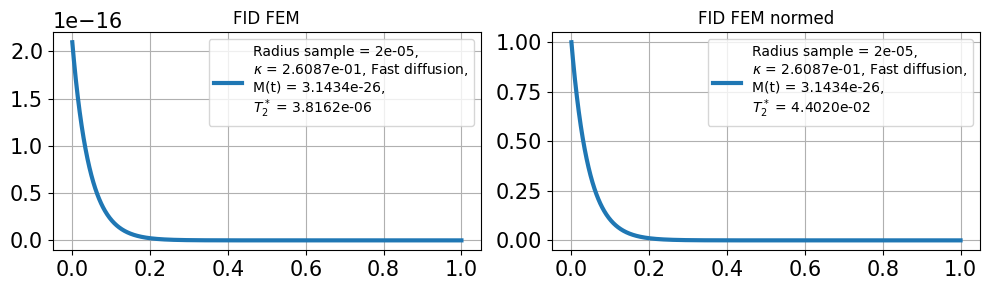

In [6]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9

times_, m_, mag_amounts_, mag_assemble_ = NMR_FEM(radius=radius_sample, aspect_ratio=1, dimension=1, mesh_res=100,
                                                         mesh_stats = True, mesh_load=None,  #mesh options
                                                         T2B=0.05, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                         B_0=0.05, Temp=303.15, fluid='water',    #initial condition ms
                                                         t_0=0, t_f=1, dt=0.001, print_time=True, #time parameters
                                                        )

T2fit_raw = T2star_fit(times_, mag_amounts_)

mag_amounts_norm = normalize_results(mag_amounts_)
T2fit_norm = T2star_fit(times_, mag_amounts_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

plot_dual_graphs(times_, mag_amounts_, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_raw[0]:.4e}', f'FID FEM',
                 times_, mag_amounts_norm, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_norm[0]:.4e}', f'FID FEM normed',
                 figsize=(10, 3))

Progress: 100%|██████| 10000/10000 [00:53<00:00, 186.69it/s]


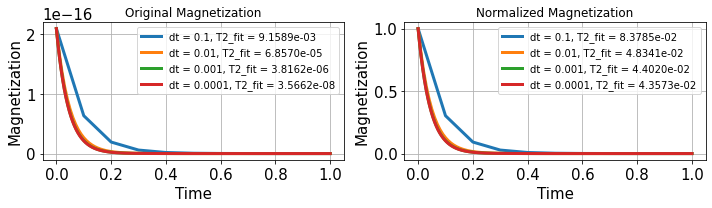

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9

dt_values = [0.1, 0.01, 0.001, 0.0001]

mag_amounts_list = []
T2fit_raw_list = []
mag_amounts_norm_list = []
T2fit_norm_list = []
times_list = []

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

for dt in dt_values:
    times_, m_, mag_amounts_, mag_assemble_ = NMR_FEM(radius=radius_sample, aspect_ratio=1, dimension=1, mesh_res=100,
                                                       mesh_stats=False, mesh_load=None,  #mesh options
                                                       T2B=0.05, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                       B_0=0.05, Temp=303.15, fluid='water',    #initial condition ms
                                                       t_0=0, t_f=1, dt=dt, print_time=True)  #time parameters

    T2fit_raw = T2star_fit(times_, mag_amounts_)
    mag_amounts_norm = normalize_results(mag_amounts_)
    T2fit_norm = T2star_fit(times_, mag_amounts_norm)
    bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

    axs[0].plot(times_, mag_amounts_, label=f'dt = {dt}, T2_fit = {T2fit_raw[0]:.4e}')
    axs[1].plot(times_, mag_amounts_norm, label=f'dt = {dt}, T2_fit = {T2fit_norm[0]:.4e}')

    mag_amounts_list.append(mag_amounts_)
    T2fit_raw_list.append(T2fit_raw)
    mag_amounts_norm_list.append(mag_amounts_norm)
    T2fit_norm_list.append(T2fit_norm)
    times_list.append(times_)

axs[0].set_title('Original Magnetization')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Magnetization')

axs[1].set_title('Normalized Magnetization')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Magnetization')

axs[0].legend()
axs[1].legend()

axs[0].grid()
axs[1].grid()

plt.tight_layout()
plt.show()

## 3D test

|Mesh statistics|
|---------------|
|hmin                | 5.1847e-06|
|hmax                | 9.9474e-06|
|num. cells          | 1185      |
|num. edges          | 0         |
|num. entities 0d    | 285       |
|num. entities 1d    | 0         |
|num. entities 2d    | 2537      |
|num. entities 3d    | 1185      |
|num. faces          | 2537      |
|num. facets         | 2537      |
|num. vertices       | 285       |
|Volume              | 3.2098e-14|[m^3]
|Surface area        | 4.9086e-09|[m^2]
|Surface to Volume ratio| 1.5293e+05|[m^-1]
|---------------|
|T2star conventional | 4.0671e-02|[s]
|---------------|


Progress: 100%|█████████| 1000/1000 [01:29<00:00, 11.15it/s]


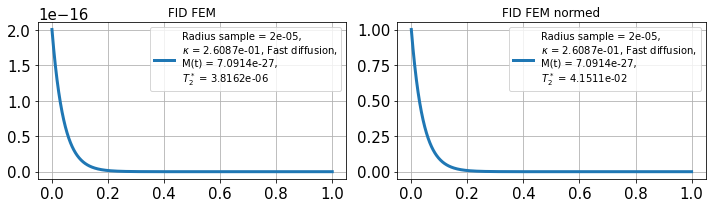

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9

times_, m_, mag_amounts_, mag_assemble_ = NMR_FEM(radius=radius_sample, aspect_ratio = 1, dimension=3,
                                                  mesh_res=8, mesh_stats = True, mesh_load=None,  #mesh options
                                                  T2B=0.05, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                  B_0=0.05, Temp=303.15, fluid='water',    #initial condition ms
                                                  t_0=0, t_f=1, dt=0.001, print_time=True, #time parameters
                                                 )

T2fit_raw = T2star_fit(times_, mag_amounts_)

mag_amounts_norm = normalize_results(mag_amounts_)
T2fit_norm = T2star_fit(times_, mag_amounts_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

plot_dual_graphs(times_, mag_amounts_, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_raw[0]:.4e}', f'FID FEM',
                 times_, mag_amounts_norm, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_norm[0]:.4e}', f'FID FEM normed',
                 figsize=(10, 3))

# Conventional

## Code

In [ ]:
#TO-DO: añadir opciones para estimar T2 bulk
def NMR_Conventional(radius=1, aspect_ratio = 1, #SV_ratio
                     T2B=1., diffusion=2.3e-9, rho=30e-6, #T2_star
                     B_0=0.05, Temp=303.15, fluid='water', #mag_sat
                     t=np.linspace(0, 1, 10000), #time must be an array
                    ):

    assert fluid in ['water', 'oil', 'gas']

    # Calculating magnetic saturation
    def mag_sat(B_0, Temp, fluid):
        assert fluid in ['water', 'oil', 'gas']
        avogadro_number = 6.0220e23
        h_planck = 6.626e-34
        k_boltzmann = 1.380e-23
        gamma = 267.5e6

        if fluid == 'water':
            number_hydrogen = 2.
            fluid_mol_weight = 18.0153e-3
            fluid_density = 9.97e2
        elif fluid == 'oil':
            number_hydrogen = 12.
            fluid_mol_weight = 72.151e-3
            fluid_density = 6.26e2
        elif fluid == 'gas':
            number_hydrogen = 4.
            fluid_mol_weight = 16.04e-3
            fluid_density = 6.56e-1

        proton_density = (number_hydrogen * avogadro_number * fluid_density) / fluid_mol_weight
        m_s = (proton_density * B_0 * (gamma**2) * (h_planck**2)) / (4. * k_boltzmann * Temp)
        return m_s

    # Calculating surface area and volume ratio
    def SV_ratio(radius, aspect_ratio):

        if aspect_ratio == 1:
            S = 4. * np.pi * np.power(radius, 2)
            V = 4. * np.pi * np.power(radius, 3) / 3.
        else:
            a = radius
            b = radius*aspect_ratio
            c = radius*aspect_ratio
            S = 4. * np.pi * (((a * b) ** 1.6 + (a * c) ** 1.6 + (b * c) ** 1.6) / 3.) ** (1. / 1.6)
            V = 4. * np.pi * a * b * c / 3.

        SVratio = S / V
        return S, V, SVratio

    S_value_geom, V_value_geom, SV_ratio_value_geom = SV_ratio(radius, aspect_ratio)

    # Calculating Amplitude
    def A(ms, V):
        Amplitude = ms * V
        return Amplitude

    # Calculating conventional T2star
    def T2star_conventional(T2B, rho, SVratio):
        if T2B <= 0:
            T_2star = 1. / (rho * SVratio)
        else:
            T_2star = 1. / ((1. / T2B) + rho * SVratio)
        return T_2star

    # Calculating NMR signal
    def nmr_signal(t, radius, aspect_ratio, T2B, rho, B_0, Temp, fluid):
        m_sat = mag_sat(B_0, Temp, fluid)
        S_value, V_value, SV_ratio_value = SV_ratio(radius, aspect_ratio)
        Amplitude_value = A(m_sat, V_value)
        T2s = T2star_conventional(T2B, rho, SV_ratio_value)
        return Amplitude_value * np.exp(-t / T2s)

    # NMR signal
    mag_amounts = nmr_signal(t, radius, aspect_ratio, T2B, rho, B_0, Temp, fluid)

    # NMR integral
    mag_assemble = quad(nmr_signal, 0, V_value_geom, args=(radius, aspect_ratio, T2B, rho, B_0, Temp, fluid))[0]

    return mag_amounts, mag_assemble

## Sphere test

Analytical volume: 3.3510e-14,
Analytical surface: 5.0265e-09, 
Analytical Surface to Volume ratio: 1.5000e+05
Analytical T2*: 4.0816e-02


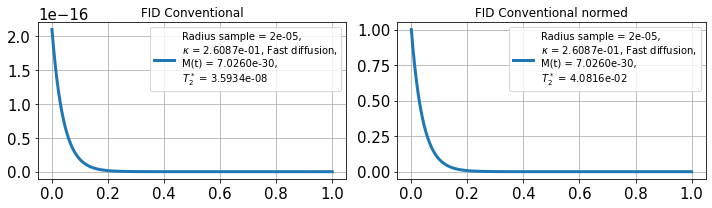

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9

Surface_sample, Volume_sample, SurfVol_ratio = SV_ratio_analytical(radius_sample, aspect_ratio=1)

print(f'Analytical volume: {Volume_sample:.4e},\nAnalytical surface: {Surface_sample:.4e}, \nAnalytical Surface to Volume ratio: {SurfVol_ratio:.4e}')
print(f'Analytical T2*: {T2star_conventional(T2B=0.05, rho=surface_relaxivity, SVratio= SurfVol_ratio):.4e}')

time_array = np.linspace(0, 1, 10000)

mag_amounts_c, mag_assemble_c = NMR_Conventional(radius=radius_sample, aspect_ratio=1,
                                 T2B=0.05, rho = surface_relaxivity,
                                 B_0=0.05, Temp=303.15, fluid='water',
                                 t=time_array,)

T2fit_raw_c = T2star_fit(time_array, mag_amounts_c)

mag_amounts_c_norm = normalize_results(mag_amounts_c)
T2fit_norm_c = T2star_fit(time_array, mag_amounts_c_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

plot_dual_graphs(xdata1=time_array, ydata1=mag_amounts_c,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_raw_c[0]:.4e}',
                 title1 = f'FID Conventional',
                 xdata2=time_array, ydata2=mag_amounts_c_norm,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_norm_c[0]:.4e}',
                 title2 =f'FID Conventional normed',
                 figsize=(10, 3))

## Ellipsoid test

Analytical volume: 8.3776e-15,
Analytical surface: 2.1460e-09, 
Analytical Surface to Volume ratio: 2.5616e+05
Analytical T2*: 3.6121e-02


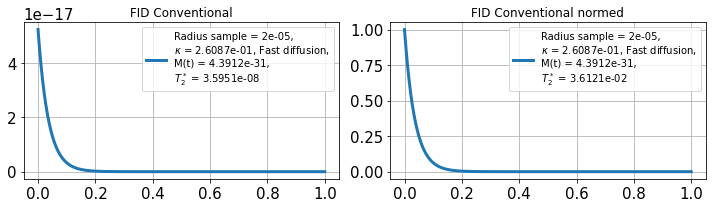

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9

Surface_sample, Volume_sample, SurfVol_ratio = SV_ratio_analytical(radius_sample, aspect_ratio=0.5)

print(f'Analytical volume: {Volume_sample:.4e},\nAnalytical surface: {Surface_sample:.4e}, \nAnalytical Surface to Volume ratio: {SurfVol_ratio:.4e}')
print(f'Analytical T2*: {T2star_conventional(T2B=0.05, rho=surface_relaxivity, SVratio= SurfVol_ratio):.4e}')

time_array = np.linspace(0, 1, 10000)

mag_amounts_c, mag_assemble_c = NMR_Conventional(radius=radius_sample, aspect_ratio=0.5,
                                                 T2B=0.05, rho = surface_relaxivity,
                                                 B_0=0.05, Temp=303.15, fluid='water',
                                                 t=time_array,)

T2fit_raw_c = T2star_fit(time_array, mag_amounts_c)

mag_amounts_c_norm = normalize_results(mag_amounts_c)
T2fit_norm_c = T2star_fit(time_array, mag_amounts_c_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

plot_dual_graphs(xdata1=time_array, ydata1=mag_amounts_c,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_raw_c[0]:.4e}',
                 title1 = f'FID Conventional',
                 xdata2=time_array, ydata2=mag_amounts_c_norm,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_norm_c[0]:.4e}',
                 title2 =f'FID Conventional normed',
                 figsize=(10, 3))

# Analytical

## Code

In [ ]:
def M_sphere(radius, rho, diffusion, T2B, n, rleft, rright, tol, t0, tf, dt,):

    def f(x):
        return float(1-(x*mpmath.cot(x)) - ((radius*rho)/diffusion))

    # Calculating magnetic saturation
    def mag_sat(B_0=0.05, Temp=303.15, fluid='water'):
        assert fluid in ['water', 'oil', 'gas']
        avogadro_number = 6.0220e23
        h_planck = 6.626e-34
        k_boltzmann = 1.380e-23
        gamma = 267.5e6

        if fluid == 'water':
            number_hydrogen = 2.
            fluid_mol_weight = 18.0153e-3
            fluid_density = 9.97e2
        elif fluid == 'oil':
            number_hydrogen = 12.
            fluid_mol_weight = 72.151e-3
            fluid_density = 6.26e2
        elif fluid == 'gas':
            number_hydrogen = 4.
            fluid_mol_weight = 16.04e-3
            fluid_density = 6.56e-1

        proton_density = (number_hydrogen * avogadro_number * fluid_density) / fluid_mol_weight
        m_s = (proton_density * B_0 * (gamma**2) * (h_planck**2)) / (4. * k_boltzmann * Temp)
        return m_s

    eigbetam = []
    root = []
    Tn_values = []

    for i in range(1, n + 1):
        a = (i - 1) * rleft + tol
        b = i * rright - tol
        r = opt.brentq(f, float(a), float(b))
        rt= np.power(r, 2)
        eigbetam.append(r)
        root.append(rt)
        Tn = np.power(radius, 2) / (diffusion * np.power(r, 2))
        Tn_values.append(Tn)

    eigbetam = np.unique(eigbetam)
    lengthv = len(eigbetam)

    volume_sphere = 4/3 * np.pi * radius**3

    def M(t):
        s = 0.0
        for i in range(0, lengthv):
            r = eigbetam[i]
            a = np.sin(r) - r * np.cos(r)
            b = np.power(r,3) * (2 * r - np.sin(2 * r))
            if T2B <= 0:
                bulk_term = 0
            else:
                bulk_term = 1/T2B
            m0 = mag_sat(B_0=0.05, Temp=303.15, fluid='water') *volume_sphere
            s +=  m0 * (12 *np.power(a,2)/ b * np.exp(-t*((1/Tn_values[0]) + bulk_term)))
        return s

    print('Analytical error = ', 1-M(0))

    t = 0.0
    NT = int((tf - t0) / dt)
    times = np.zeros(NT + 1)
    MM = np.zeros(NT + 1)

    for i in range(0, NT + 1):
        t = i * dt
        times[i] = t
        MM[i] = M(t)

    # NMR integral
    mag_assemble = quad(M, 0, volume_sphere)[0]

    return times, MM, eigbetam, root, Tn_values, mag_assemble

## Sphere test

error =  0.9999999999999998


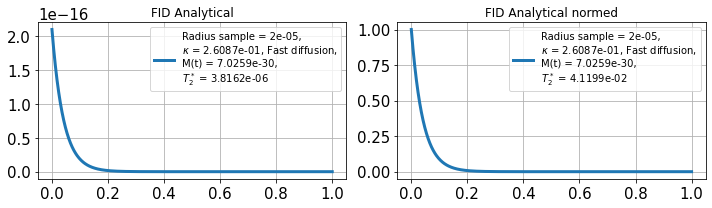

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9

times_, MM_, eigbetam_, root_, Tn_values_, mag_assemble_ = M_sphere(radius=radius_sample,
         rho=surface_relaxivity, diffusion=diffusion_water, T2B=0.05,
         n=10, rleft=np.pi, rright=np.pi, tol=1.e-6,
         t0=0, tf=1, dt=0.001,)

T2fit_raw_a = T2star_fit(times_, MM_)

mag_amounts_a_norm = normalize_results(MM_)
T2fit_norm_a = T2star_fit(times_, mag_amounts_a_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

plot_dual_graphs(xdata1=times_, ydata1=MM_,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_raw_a[0]:.4e}',
                 title1 = f'FID Analytical',
                 xdata2=times_, ydata2=mag_amounts_a_norm,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_norm_a[0]:.4e}',
                 title2 =f'FID Analytical normed',
                 figsize=(10, 3))

# Comparative cases

## Numerical vs Analytical

|Mesh statistics|
|---------------|
|hmin                | 2.0000e-07|
|hmax                | 2.0000e-07|
|num. cells          | 100       |
|num. edges          | 100       |
|num. entities 0d    | 101       |
|num. entities 1d    | 100       |
|num. entities 2d    | 0         |
|num. entities 3d    | 0         |
|num. faces          | 0         |
|num. facets         | 101       |
|num. vertices       | 101       |
|Volume              | 3.3510e-14|[m^3]
|Surface area        | 5.0265e-09|[m^2]
|Surface to Volume ratio| 1.5000e+05|[m^-1]
|---------------|
|T2star conventional | 4.0816e-02|[s]
|---------------|


Progress: 100%|████████| 1000/1000 [00:05<00:00, 179.99it/s]


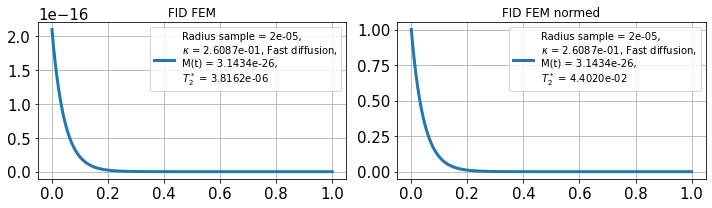

--------------------------------------------
Analytical error =  0.9999999999999998


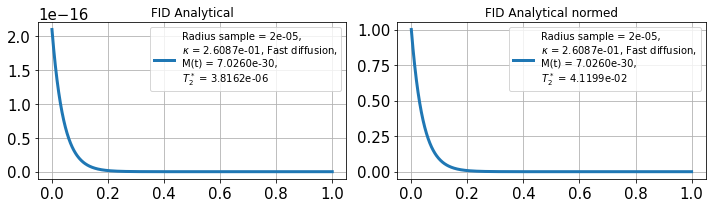

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2Bulk = 0.05
B0 = 0.05
Temperature = 303.15
fluid_sample = 'water'
t0 = 0
tf = 1
dt = 0.001

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

#Numerical case
times_num, m_num, mag_amounts_num, mag_assemble_num = NMR_FEM(radius=radius_sample, aspect_ratio=1, dimension=1, mesh_res=100,
                                                         mesh_stats = True, mesh_load=None,  #mesh options
                                                         T2B=T2Bulk, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                         B_0=B0, Temp=Temperature, fluid=fluid_sample,    #initial condition ms
                                                         t_0=t0, t_f=tf, dt=dt, print_time=True, #time parameters
                                                        )

T2fit_raw_num = T2star_fit(times_num, mag_amounts_num)

mag_amounts_norm_num = normalize_results(mag_amounts_num)
T2fit_norm_num = T2star_fit(times_num, mag_amounts_norm_num)

plot_dual_graphs(times_num, mag_amounts_num, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_raw_num[0]:.4e}', f'FID FEM',
                 times_num, mag_amounts_norm_num, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_norm_num[0]:.4e}', f'FID FEM normed',
                 figsize=(10, 3))

print('--------------------------------------------')

#Analytical case
times_an, MM_an, eigbetam_an, root_an, Tn_values_an, mag_assemble_an = M_sphere(radius=radius_sample,
         rho=surface_relaxivity, diffusion=diffusion_water, T2B=T2Bulk,
         n=1000, rleft=np.pi, rright=np.pi, tol=1.e-6,
         t0=t0, tf=tf, dt=dt,)

T2fit_raw_an = T2star_fit(times_an, MM_an)

mag_amounts_norm_an = normalize_results(MM_an)
T2fit_norm_an = T2star_fit(times_an, mag_amounts_norm_an)

plot_dual_graphs(xdata1=times_an, ydata1=MM_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_raw_an[0]:.4e}',
                 title1 = f'FID Analytical',
                 xdata2=times_an, ydata2=mag_amounts_norm_an,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_norm_an[0]:.4e}',
                 title2 =f'FID Analytical normed',
                 figsize=(10, 3))

In [ ]:
absolute_error_num_vs_an, relative_error_num_vs_an = error_estimation(MM_an, mag_amounts_num)
absolute_error_num_vs_an_norm, relative_error_num_vs_an_norm = error_estimation(mag_amounts_norm_an, mag_amounts_norm_num)

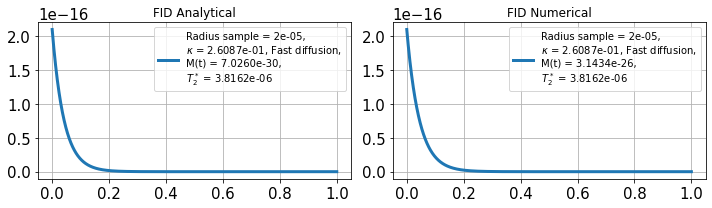

In [ ]:
plot_dual_graphs(xdata1=times_an, ydata1=MM_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_raw_an[0]:.4e}',
                 title1 = f'FID Analytical',
                 xdata2=times_num, ydata2=mag_amounts_num,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_raw_num[0]:.4e}',
                 title2 =f'FID Numerical',
                 figsize=(10, 3))

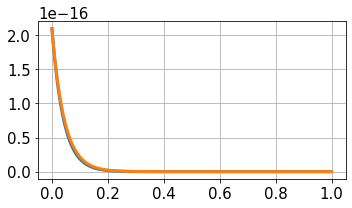

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(times_an, MM_an,)
plt.plot(times_num, mag_amounts_num,)
plt.grid()

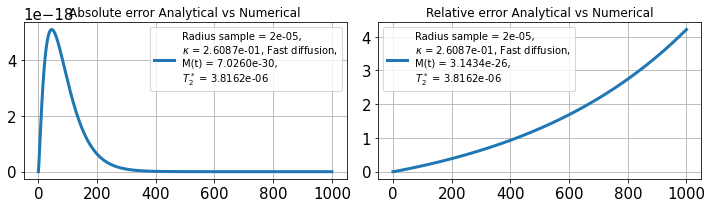

In [ ]:
plot_dual_graphs(xdata1=np.arange(absolute_error_num_vs_an.size), ydata1=absolute_error_num_vs_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_raw_an[0]:.4e}',
                 title1 = f'Absolute error Analytical vs Numerical',
                 xdata2=np.arange(relative_error_num_vs_an.size), ydata2=relative_error_num_vs_an,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_raw_num[0]:.4e}',
                 title2 =f'Relative error Analytical vs Numerical',
                 figsize=(10, 3))

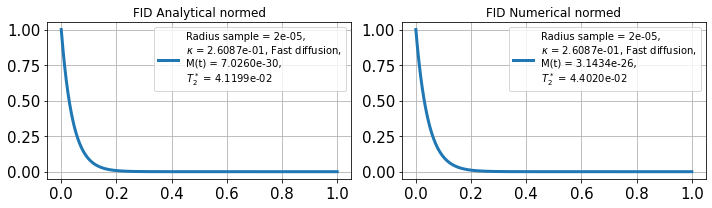

In [ ]:
plot_dual_graphs(xdata1=times_an, ydata1=mag_amounts_norm_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_norm_an[0]:.4e}',
                 title1 = f'FID Analytical normed',
                 xdata2=times_num, ydata2=mag_amounts_norm_num,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_norm_num[0]:.4e}',
                 title2 =f'FID Numerical normed',
                 figsize=(10, 3))

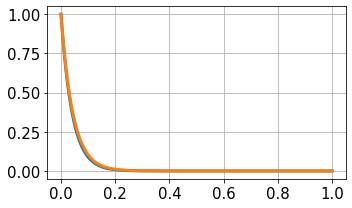

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(times_an, mag_amounts_norm_an)
plt.plot(times_num, mag_amounts_norm_num)
plt.grid()

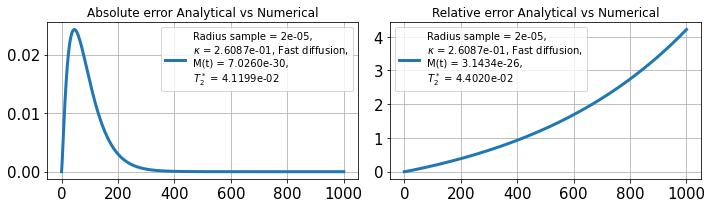

In [ ]:
plot_dual_graphs(xdata1=np.arange(absolute_error_num_vs_an_norm.size), ydata1=absolute_error_num_vs_an_norm,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_norm_an[0]:.4e}',
                 title1 = f'Absolute error Analytical vs Numerical',
                 xdata2=np.arange(relative_error_num_vs_an_norm.size), ydata2=relative_error_num_vs_an_norm,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_norm_num[0]:.4e}',
                 title2 =f'Relative error Analytical vs Numerical',
                 figsize=(10, 3))

## Conventional vs Analytical

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2Bulk = 0.05
B0 = 0.05
Temperature = 303.15
fluid_sample = 'water'
t0 = 0
tf = 1
dt = 0.001

nt = int((tf-t0)/dt) + 1
times_array = np.linspace(t_0, t_f, nt)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

#Conventional case
Surface_sample, Volume_sample, SurfVol_ratio = SV_ratio_analytical(radius_sample, aspect_ratio=1)

print(f'Analytical volume: {Volume_sample:.4e},\nAnalytical surface: {Surface_sample:.4e}, \nAnalytical Surface to Volume ratio: {SurfVol_ratio:.4e}')
print(f'Analytical T2*: {T2star_conventional(T2B=0.05, rho=surface_relaxivity, SVratio= SurfVol_ratio):.4e}')

mag_amounts_c, mag_assemble_c = NMR_Conventional(radius=radius_sample, aspect_ratio=1,
                                 T2B=T2Bulk, rho = surface_relaxivity,
                                 B_0=B0, Temp=Temperature, fluid=fluid_sample,
                                 t=times_array,)

T2fit_raw_c = T2star_fit(time_array, mag_amounts_c)

mag_amounts_c_norm = normalize_results(mag_amounts_c)
T2fit_norm_c = T2star_fit(time_array, mag_amounts_c_norm)

plot_dual_graphs(xdata1=time_array, ydata1=mag_amounts_c,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_raw_c[0]:.4e}',
                 title1 = f'FID Conventional',
                 xdata2=time_array, ydata2=mag_amounts_c_norm,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_norm_c[0]:.4e}',
                 title2 =f'FID Conventional normed',
                 figsize=(10, 3))

print('--------------------------------------------')

#Analytical case
times_an, MM_an, eigbetam_an, root_an, Tn_values_an, mag_assemble_an = M_sphere(radius=radius_sample,
         rho=surface_relaxivity, diffusion=diffusion_water, T2B=T2Bulk,
         n=1000, rleft=np.pi, rright=np.pi, tol=1.e-6,
         t0=t0, tf=tf, dt=dt,)

T2fit_raw_an = T2star_fit(times_an, MM_an)

mag_amounts_norm_an = normalize_results(MM_an)
T2fit_norm_an = T2star_fit(times_an, mag_amounts_norm_an)

plot_dual_graphs(xdata1=times_an, ydata1=MM_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_raw_an[0]:.4e}',
                 title1 = f'FID Analytical',
                 xdata2=times_an, ydata2=mag_amounts_norm_an,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_norm_an[0]:.4e}',
                 title2 =f'FID Analytical normed',
                 figsize=(10, 3))